In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.feature import hog

# Initialize Variable

In [2]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
orient = 9  # HOG orientations
pix_per_cell = 12 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

# Hog Feature Extraction

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Spatial Feature Extraction

In [4]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Hist Feature Extraction

In [5]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Extracting All Features

In [6]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space, spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'BGR':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Loading Image

In [8]:
# Divide up into cars and notcars
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
images_cars = glob.glob('vehicles/*.png')
images_notcars = glob.glob('non_vehicles/*.png')
cars = []
notcars = []
for image in images_cars:
    cars.append(image)
for image in images_notcars:
    notcars.append(image)

C:\Users\sanchit.agrawal\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Training

In [9]:
t=time.time()
car_features = extract_features(cars, color_space, spatial_size,hist_bins,orient, 
                        pix_per_cell, cell_per_block, 
                        hog_channel,spatial_feat, hist_feat, hog_feat)
notcar_features = extract_features(notcars, color_space, spatial_size,hist_bins,orient, 
                        pix_per_cell, cell_per_block, 
                        hog_channel,spatial_feat, hist_feat, hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

"""
############################SVC###########
from sklearn.svm import SVC
svc = SVC(C=10.0,kernel="rbf")
t=time.time()
svc.fit(X_train,y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
#### now your job is to fit the classifier
#### using the training features/labels, and to
#### make a set of predictions on the test data
#### store your predictions in a list named pred
pred = svc.predict(X_test)
from sklearn.metrics import accuracy_score
acc = accuracy_score(pred, y_test)
print('Test Accuracy of SVC = ', round(acc, 4))
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
############################SVC###############
"""
 # Use a linear SVC 
svc = LinearSVC()
# # Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# # Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# # Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

84.15 Seconds to extract HOG features...
Using: 9 orientations 12 pixels per cell and 2 cells per block
Feature vector length: 4896
11.17 Seconds to train SVC...
Test Accuracy of SVC =  0.9915
My SVC predicts:  [ 1.  1.  0.  0.  0.  0.  1.  1.  1.  0.]
For these 10 labels:  [ 1.  1.  0.  0.  0.  0.  1.  1.  1.  0.]
0.0024 Seconds to predict 10 labels with SVC


# Saving Model

In [26]:
import pickle
with open('model_linear1.pickle','wb') as f:
    pickle.dump(svc,f)
    pickle.dump(X_scaler,f)

# Adding Heat

In [9]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

# Applying Threshold

In [10]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# Drawing Labeled Boxes

In [28]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        if (((bbox[1][1]-bbox[0][1])-(bbox[1][0]-bbox[0][0]))>5):
            continue
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Converting Color

In [12]:
def convert_color(img, conv):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'BGR2LUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2LUV)

# Loading Test Image

In [242]:
svc_pass = svc
X_scaler_pass = X_scaler
img = cv2.imread('video_frames/635.jpg')

# Function to find Cars

5


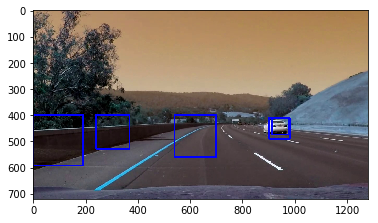

In [19]:
box_list = []
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
#     draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    global box_list
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='BGR2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_features = X_scaler.transform(np.hstack((spatial_features,hist_features,hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            #print(scale,"  ",test_prediction)
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
#                 cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return box_list
    
ystart = 400
ystop = (464,480,496,528,560,592)
scale = (1.0,1.25,1.5,2,2.5,3)

draw_img = np.copy(img)
box = []
for i in range(len(ystop)):
    box = find_cars(img, ystart, ystop[i], scale[i], svc_pass, X_scaler_pass, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
box = find_cars(img, 410, 485, 1.25, svc_pass, X_scaler_pass, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
box = find_cars(img, 410, 474, 1, svc_pass, X_scaler_pass, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

for i in box:
    cv2.rectangle(draw_img,(i[0][0], i[0][1]),(i[1][0], i[1][1]),(0,0,255),6)  
%matplotlib inline
plt.imshow(draw_img)

# Calling Heat, Threshold and Drawing label Image 

In [20]:
from scipy.ndimage.measurements import label
def heat_map(heat,box,img,threshold):
    # Add heat to each box in box list
    heat1 = add_heat(heat,box)

    # Apply threshold to help remove false positives
    heat1 = apply_threshold(heat1,threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat1, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    #plt.imshow(draw_img)
    return draw_img,heatmap

# Plotting Labeled and Heat Image

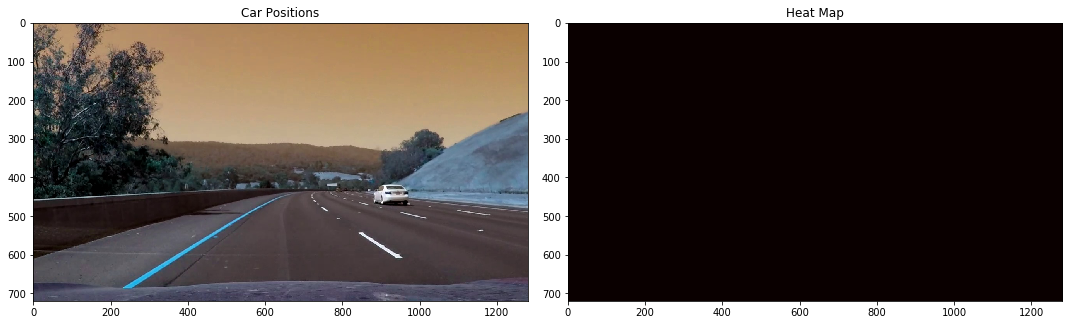

In [21]:
heat = np.zeros_like(img[:,:,0]).astype(np.float)
thres = 2
draw_image,heatmap=heat_map(heat,box,img,thres)
fig = plt.figure(figsize=(15,6))
plt.subplot(121)
plt.imshow(draw_image)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

# Load Model

In [14]:
import pickle
with open('model_linear1.pickle','rb') as f:
    svc=pickle.load(f)
    X_scaler=pickle.load(f)

EOFError: Ran out of input

# Creating Video

In [30]:
import cv2
import matplotlib.pyplot as plt
from collections import deque 
# For deque
avg= deque(maxlen=30)
box_list = []
box = []
# Creating a Video capture object
cap = cv2.VideoCapture('project_video.mp4')

# Getting width and height of frame
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
thres = 35
# Creating a Video writer object
out = cv2.VideoWriter('output.mp4',cv2.VideoWriter_fourcc(*'XVID'), 10,(frame_width,frame_height))
while 1:
  # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
        for i in range(len(ystop)):
            box = find_cars(frame, ystart, ystop[i], scale[i], svc_pass, X_scaler_pass, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
            #print(len(box))
        box = find_cars(img, 410, 485, 1.25, svc_pass, X_scaler_pass, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        box = find_cars(img, 410, 474, 1, svc_pass, X_scaler_pass, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#             heat = np.zeros_like(img[:,:,0]).astype(np.float)
#             draw_image,heatmap=heat_map(heat,box,frame,thres)
        #out_frame,box = find_cars(frame,ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        box_list = []
        heat = np.zeros_like(frame[:,:,0]).astype(np.float)
        from scipy.ndimage.measurements import label
        # Add heat to each box in box list
        heat = add_heat(heat,box)
        avg.append(heat)
        avg_heatmap=np.sum(avg,axis=0)

        # Apply threshold to help remove false positives
        heat = apply_threshold(avg_heatmap,72)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(frame), labels)


        out.write(np.uint8(draw_img))
        
  # Break the loop
    else: 
        break

# Release all resources
cap.release()
out.release()
cv2.destroyAllWindows()

print("done")

0
2
5
5
5
6
1
2
4
5
5
5
3
4
5
5
5
7
1
2
4
4
4
5
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
2
0
2
2
2
3
3
0
0
0
0
0
0
0
1
1
1
1
1
0
1
1
1
1
2
0
1
1
1
1
1
0
1
1
1
1
1
0
1
1
1
1
1
0
1
1
1
1
1
0
1
1
1
1
1
0
1
1
1
1
1
1
2
2
2
2
2
1
2
2
2
2
2
1
2
2
2
2
2
0
1
1
1
1
1
0
1
1
2
2
2
0
1
1
1
2
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
1
2
2
2
2
0
1
1
1
1
1
0
1
1
1
1
1
0
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
2
2
2
3
0
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
0
0
2
2
2
2
0
1
2
2
2
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
0
0
0
0
0
0
0
1
1
1
1
1
0
0
0
0
0
0
0
1
2
2
2
3
0
1
1
1
1
1
0
0
0
0
1
2
0
1
1
1
2
3
0
1
1
2
3
4
0
1
2
3
3
4
0
1
3
4
5
6
0
1
3
4
5
6
0
1
2
3
4
5
0
1
3
4
5
6
1
2
5
7
8
9
1
2
5
8
9
10
0
3
6
8
9
10
2
3
6
8
9
10
1
3
5
7
8
10
0
1
3
6
8
10
3
4
5
8
10
11
1
2
5
8
10
12
3
6
9
12
15
17
3
3
7
10
12
14
3
4
8
10
12
14
2
4
7
10
12
14
2
5
8
10
12
15
4
8
10
13
15
17
2
3
6
9
11
13
1
3
5
9
11
14
2
3
6
10
12
14

7
7
7
2
4
6
6
6
6
3
5
8
8
8
8
2
4
6
7
7
7
2
3
5
5
5
5
2
4
6
7
7
7
1
3
5
5
5
5
3
5
7
7
7
7
2
4
6
6
6
6
2
4
6
6
6
6
1
2
4
4
4
4
1
3
5
5
5
6
1
3
5
6
6
7
1
3
5
5
5
5
1
3
5
5
5
5
2
4
6
6
6
6
2
4
6
6
6
6
1
4
7
8
8
9
1
3
5
6
6
6
2
3
5
6
6
6
1
2
4
4
4
4
1
2
4
4
4
4
1
2
4
5
5
5
1
2
4
5
5
5
1
2
4
5
5
6
1
3
5
6
6
7
2
5
7
7
7
7
3
6
8
8
8
8
3
6
9
9
9
9
3
5
7
7
7
8
3
6
8
8
8
9
3
6
9
9
9
9
3
5
7
7
7
7
3
5
7
8
9
9
3
6
8
9
9
10
3
6
8
8
8
9
2
5
7
8
8
9
4
5
7
8
8
8
2
5
7
8
8
8
2
5
7
8
8
8
2
3
5
6
6
6
2
3
5
5
5
5
2
3
5
5
5
5
3
6
9
9
9
9
2
4
6
6
6
6
2
5
7
7
7
8
2
5
7
8
8
9
2
4
6
6
6
6
2
4
6
6
6
6
2
4
6
6
6
6
2
4
6
6
6
6
2
4
5
5
5
5
2
5
6
6
6
6
3
5
7
7
7
7
3
5
6
7
7
7
3
5
7
7
7
7
4
6
7
7
7
7
3
5
7
9
9
9
3
5
6
7
8
8
3
5
6
7
9
9
4
7
8
8
8
8
4
8
9
9
9
9
4
6
7
7
7
8
3
5
6
8
8
9
4
6
7
7
7
8
4
6
7
8
8
8
4
6
7
7
7
7
4
6
7
7
7
8
3
6
7
8
8
9
3
6
7
8
8
8
3
5
6
6
6
6
2
4
5
5
5
5
2
4
5
5
6
6
3
6
8
8
8
8
2
5
7
7
7
7
2
5
7
7
7
7
2
5
7
7
7
7
3
6
8
8
8
8
4
8
10
10
10
10
4
6
9
9
9
10
4
6
9
9
9
10
5
9
12
12
12
12
5
9
12
13
1